# Group 14 - Project FP01
## Time series anomaly detection - RNN-EBM

This project aims at investigating the current state-of-the-arts TAD scenario.

In [1]:
# !pip install pandas==1.5.3
# !pip install tsfel
# !pip install keras_tuner
# !pip install -U kaleido

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from dataset import *
from plots import *
from metrics import *

#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [3]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL =  '../dataset/normal'#'/content/drive/MyDrive/Kuka_v1/normal'
ROOTDIR_DATASET_ANOMALY = '../dataset/collisions'#'/content/drive/MyDrive/Kuka_v1/collisions'

# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Dataset: Kuka-v1
In 5 different recording sessions, the robot executes several different operations, while being
monitored by several sensors. The sensed signals are collected, with different sampling frequencies
(1, 10, 100, 200 Hz),

### Data Loading

In [4]:

#freq = '1.0'
freq = '0.1'
#freq = '0.01'
#freq = '0.005'

# NORMAL DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.metadata") for r in [0, 2, 3, 4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)

# COLLISION DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.csv") for r in [1, 5]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.metadata") for r in [1, 5]]
df_action_collision, df_collision, df_meta_collision, action2int_collision = get_df_action(filepath_csv, filepath_meta)

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec1_collision_20220811_rbtc_{freq}s.csv")]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec1_collision_20220811_rbtc_{freq}s.metadata")]
df_action_collision_1, df_collision_1, df_meta_collision_1, action2int_collision_1 = get_df_action(filepath_csv, filepath_meta)

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec5_collision_20220811_rbtc_{freq}s.csv")]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec5_collision_20220811_rbtc_{freq}s.metadata")]
df_action_collision_5, df_collision_5, df_meta_collision_5, action2int_collision_5 = get_df_action(filepath_csv, filepath_meta)

# COLLISION LABEL
xls = pd.ExcelFile(os.path.join(ROOTDIR_DATASET_ANOMALY, "20220811_collisions_timestamp.xlsx"))
collision_rec1 = pd.read_excel(xls, 'rec1')

collisions_adjusted_rec_1 = collision_rec1.Timestamp - pd.to_timedelta([2] * len(collision_rec1.Timestamp), 'h')
collision_rec1['Timestamp'] = collisions_adjusted_rec_1
collision_rec1 = collision_rec1[collision_rec1['Timestamp'] <= df_collision_1.index[-1]]
collision_rec1['Timestamp'] = collisions_adjusted_rec_1
collisions_init1 = collision_rec1[collision_rec1['Inizio/fine'] == "i"].Timestamp

collision_rec5 = pd.read_excel(xls, 'rec5')
collisions_adjusted_rec_5 = collision_rec5.Timestamp - pd.to_timedelta([2] * len(collision_rec5.Timestamp), 'h')
collision_rec5['Timestamp'] = collisions_adjusted_rec_5
collisions_init5 = collision_rec5[collision_rec5['Inizio/fine'] == "i"].Timestamp

collisions = pd.concat([collision_rec1, collision_rec5])
collisions_init = collisions[collisions['Inizio/fine'] == "i"].Timestamp

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.



In [5]:
collisions

,Inizio/fine,Timestamp
0,i,2022-08-11 14:02:17.450
1,f,2022-08-11 14:02:21.460
2,i,2022-08-11 14:02:28.320
3,f,2022-08-11 14:02:31.420
4,i,2022-08-11 14:02:45.770
...,...,...
107,f,2022-08-11 17:03:02.080
108,i,2022-08-11 17:03:44.090
109,f,2022-08-11 17:03:48.150
110,i,2022-08-11 17:04:10.600


In [6]:
collision_rec1

,Inizio/fine,Timestamp
0,i,2022-08-11 14:02:17.450
1,f,2022-08-11 14:02:21.460
2,i,2022-08-11 14:02:28.320
3,f,2022-08-11 14:02:31.420
4,i,2022-08-11 14:02:45.770
...,...,...
69,f,2022-08-11 14:28:39.970
70,i,2022-08-11 14:29:17.140
71,f,2022-08-11 14:29:19.660
72,i,2022-08-11 14:29:41.210


In [7]:
collision_rec5

,Inizio/fine,Timestamp
0,i,2022-08-11 16:44:43.810
1,f,2022-08-11 16:44:46.220
2,i,2022-08-11 16:44:56.230
3,f,2022-08-11 16:45:00.440
4,i,2022-08-11 16:45:11.420
...,...,...
107,f,2022-08-11 17:03:02.080
108,i,2022-08-11 17:03:44.090
109,f,2022-08-11 17:03:48.150
110,i,2022-08-11 17:04:10.600


In [8]:
collisions_init

0     2022-08-11 14:02:17.450
2     2022-08-11 14:02:28.320
4     2022-08-11 14:02:45.770
6     2022-08-11 14:02:57.490
8     2022-08-11 14:03:56.960
                ...          
102   2022-08-11 17:01:56.990
104   2022-08-11 17:02:11.180
106   2022-08-11 17:02:58.080
108   2022-08-11 17:03:44.090
110   2022-08-11 17:04:10.600
Name: Timestamp, Length: 93, dtype: datetime64[ns]

### Features Exctraction

In [9]:
start_time = time.time()
frequency = 1/float(freq)
df_features = get_features_ts("statistical", df_action, df_meta, frequency, action2int)
df_features_collision = get_features_ts("statistical", df_action_collision, df_meta_collision, frequency, action2int_collision)
df_features_collision_1 = get_features_ts("statistical", df_action_collision_1, df_meta_collision_1, frequency, action2int_collision_1)
df_features_collision_5 = get_features_ts("statistical", df_action_collision_5, df_meta_collision_5, frequency, action2int_collision_5)
print("--- %s seconds ---" % (time.time() - start_time))

Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
Computing features done.
Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features done.
Computing features.


Computing features done.
Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features done.
--- 159.33974623680115 seconds ---


In [11]:
collisions_zones = find_collisions_zones(collisions)
collisions_zones_1 = find_collisions_zones(collision_rec1)
collisions_zones_5 = find_collisions_zones(collision_rec5)

In [12]:
X_train, y_train, X_test, y_test, X_test_start_end = get_train_test_data(df_features, df_features_collision, full_normal=True)
X_train1, y_train1, X_test1, y_test1, X_test_start_end1 = get_train_test_data(df_features, df_features_collision_1, full_normal=True)
X_train5, y_train5, X_test5, y_test5,  X_test_start_end5 = get_train_test_data(df_features, df_features_collision_5, full_normal=True)

In [13]:
def label_collision_data(df_features, collisions_init):
# Create a binary label column initialized to 0 (no collision)
    df_features['is_collision'] = 0

    # Iterate over each collision interval
    for collision_time in collisions_init:
        mask = (df_features['start'] <= collision_time) & (df_features['end'] >= collision_time)
        
        df_features.loc[mask, 'is_collision'] = 1

    return df_features

In [14]:
df_with_labels = label_collision_data(df_features_collision, collisions_init)
df_with_labels_1 = label_collision_data(df_features_collision_1, collisions_init1)
df_with_labels_5 = label_collision_data(df_features_collision_5, collisions_init5)

In [15]:
y_collision = df_with_labels['is_collision']
y_collision_1 = df_with_labels_1['is_collision']
y_collision_5 = df_with_labels_5['is_collision']

In [16]:
np.count_nonzero(y_collision), np.count_nonzero(y_collision_1), np.count_nonzero(y_collision_5)

(91, 35, 56)

## RNN-EBM


In [17]:
from algorithms.rnn_ebm import RecurrentEBM

# Disable eager execution
tf.compat.v1.disable_eager_execution()

classifier = RecurrentEBM(
    num_epochs=500,
    n_hidden=64,
    n_hidden_recurrent=128,
    min_lr=1e-3,
    min_energy=None,  # We'll set this to None initially and determine it after training
    batch_size=64,
    seed=42,
    gpu=None  # Set to None for CPU, or specify GPU index if available
)
# Train the RNN on normal data
classifier.fit(X_train)
print("RNN-EBM training completed.")


100%|██████████| 500/500 [01:07<00:00,  7.43it/s]

RNN-EBM training completed.


In [18]:
anomaly_scores = predict_anomaly_score(X_test, classifier)
anomaly_scores1 = predict_anomaly_score(X_test1, classifier)
anomaly_scores5 = predict_anomaly_score(X_test5, classifier)

Anomaly prediction completed.
Anomaly prediction completed.
Anomaly prediction completed.


In [19]:
thresholds = compute_various_thresholds(anomaly_scores)
thresholds_1 = compute_various_thresholds(anomaly_scores1)
thresholds_5 = compute_various_thresholds(anomaly_scores5)

Number of anomalies detected: 7 with threshold 571.7432098388672, std
Number of anomalies detected: 120 with threshold 36.41061019897461, mad
Number of anomalies detected: 16 with threshold 357.3466491699219, percentile
Number of anomalies detected: 8 with threshold 397.78064465522766, IQR

Number of anomalies detected: 5 with threshold 357.0821113586426, std
Number of anomalies detected: 47 with threshold 24.012045860290527, mad
Number of anomalies detected: 9 with threshold 290.8677322387695, percentile
Number of anomalies detected: 20 with threshold 71.56992650032043, IQR

Number of anomalies detected: 3 with threshold 510.08872985839844, std
Number of anomalies detected: 8 with threshold 373.2455749511719, mad
Number of anomalies detected: 8 with threshold 376.26251220703125, percentile
Number of anomalies detected: 3 with threshold 543.918532371521, IQR



### Anomaly Detection

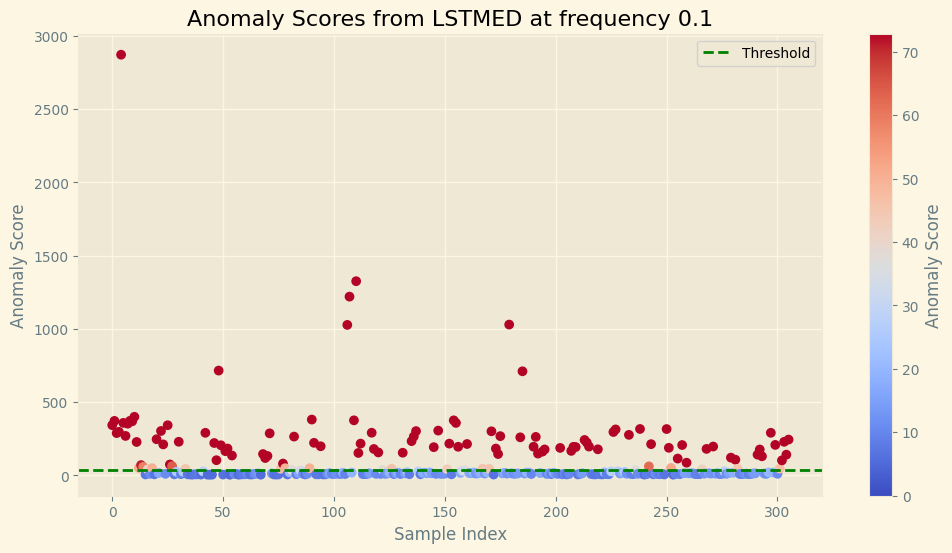

Number of anomalies detected: 120


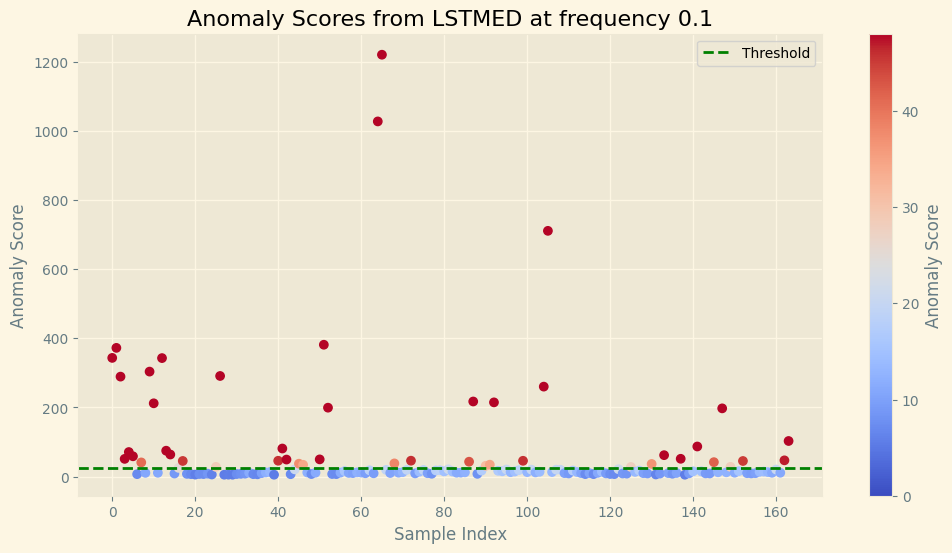

Number of anomalies detected: 47


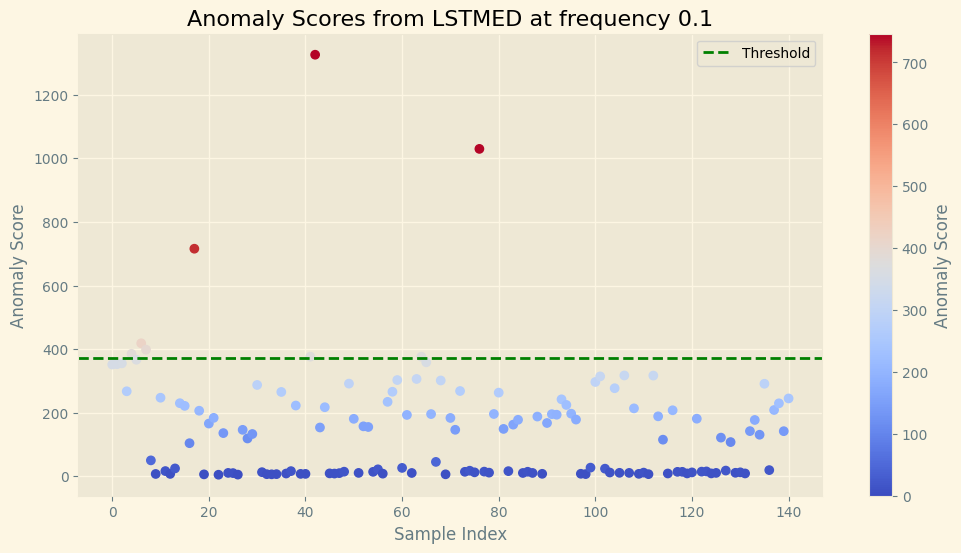

Number of anomalies detected: 8


In [20]:
anomalies_detected = plot_anomalies(anomaly_scores, freq, thresholds[1])
anomalies_detected1 = plot_anomalies(anomaly_scores1, freq, thresholds_1[1])
anomalies_detected5 = plot_anomalies(anomaly_scores5, freq, thresholds_5[1])

In [21]:
np.count_nonzero(y_collision), np.count_nonzero(y_collision_1), np.count_nonzero(y_collision_5)

(91, 35, 56)

In [22]:
compute_metrics(anomaly_scores, y_collision, thresholds[1])
print("############################################")
compute_metrics(anomaly_scores1, y_collision_1, thresholds_1[1])
print("############################################")
compute_metrics(anomaly_scores5, y_collision_5, thresholds_5[1])

ROC AUC Score: 0.9146
Detected anomaly class: 1
Threshold: 36.4106
F1 Score: 0.8341
Accuracy: 0.8856
Precision: 0.7333
Recall: 0.9670
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       215
           1       0.73      0.97      0.83        91

    accuracy                           0.89       306
   macro avg       0.86      0.91      0.87       306
weighted avg       0.91      0.89      0.89       306

############################################
ROC AUC Score: 0.9732
Detected anomaly class: 1
Threshold: 24.0120
F1 Score: 0.8537
Accuracy: 0.9268
Precision: 0.7447
Recall: 1.0000
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       129
           1       0.74      1.00      0.85        35

    accuracy                           0.93       164
   macro avg       0.87      0.95      0.90       164
weighted avg       0.95      0.93      0.93       164

#################################

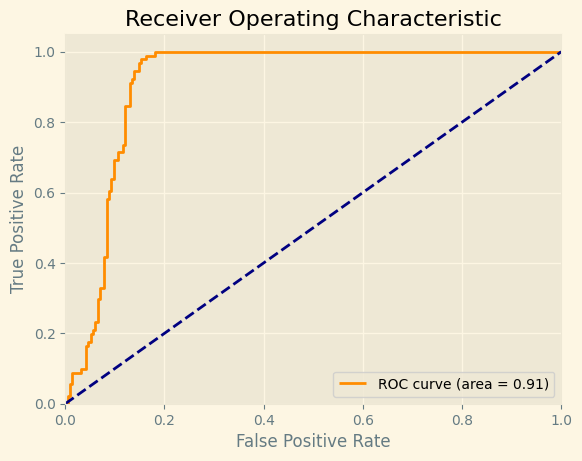

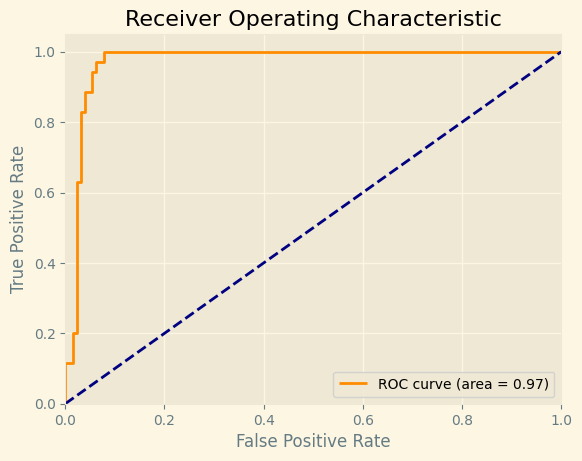

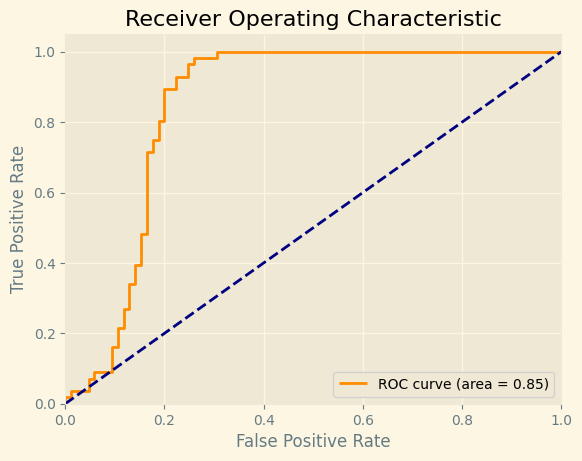

In [23]:
plot_roc_curve(y_collision, anomaly_scores)
plot_roc_curve(y_collision_1, anomaly_scores1)
plot_roc_curve(y_collision_5, anomaly_scores5)

## Map anomalies to original time series

In [44]:
def plot_anomalies_over_time(X_test, anomaly_scores, anomalies_detected, freq, threshold, collision_zones, X_test_start_end):
    # Create a DataFrame with the original data and anomaly scores
    df = pd.DataFrame(X_test)
    df['anomaly_score'] = anomaly_scores

    # Use the actual start and end times from the test set to create timestamps
    timestamps = pd.date_range(start=X_test_start_end['start'].iloc[0], end=X_test_start_end['end'].iloc[-1], periods=len(df))
    df['timestamp'] = timestamps

    # Select features to plot along with the anomaly scores
    features_to_plot = df.columns.drop(['anomaly_score', 'timestamp'])

    # Create the plot
    fig, ax1 = plt.subplots(figsize=(15, 6))
    ax1.set_title(f'Time Series Data with Anomaly Scores at frequency {freq}', fontsize=16)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Feature Values')

    # Plot each feature with a different shade
    colors = plt.cm.Greys(np.linspace(0, 1, len(features_to_plot)))
    for feature, color in zip(features_to_plot, colors):
        ax1.plot(df['timestamp'], df[feature], label=f'Feature: {feature}', color=color, linewidth=1, alpha=0.7)

    # Highlight collision zones
    for index, row in collision_zones.iterrows():
        ax1.axvspan(row['start'], row['end'], color='blue', alpha=0.3, label='Collision Zone' if index == 0 else "")

    # Plot anomaly scores
    ax2 = ax1.twinx()
    ax2.set_ylabel('Anomaly Score', color='red')
    ax2.plot(df['timestamp'], df['anomaly_score'], color='red', linestyle='--', linewidth=2, label='Anomaly Score')
    ax2.tick_params(axis='y', labelcolor='red')

    # Draw threshold line
    ax2.axhline(y=threshold, color='green', linestyle='--', label='Threshold', linewidth=2)

    # Highlight top N anomalies
    top_anomalies = df.nlargest(anomalies_detected, 'anomaly_score')
    for time in top_anomalies['timestamp']:
        ax1.axvline(x=time, color='magenta', linestyle='--', alpha=0.5, label='Detected Anomaly (Top N)' if time == top_anomalies['timestamp'].iloc[0] else "")

    plt.tight_layout()
    plt.show()

    # Print details of top anomalies
    print("Top", anomalies_detected, "Anomalies:")
    print(top_anomalies[['timestamp', 'anomaly_score'] + list(features_to_plot)])

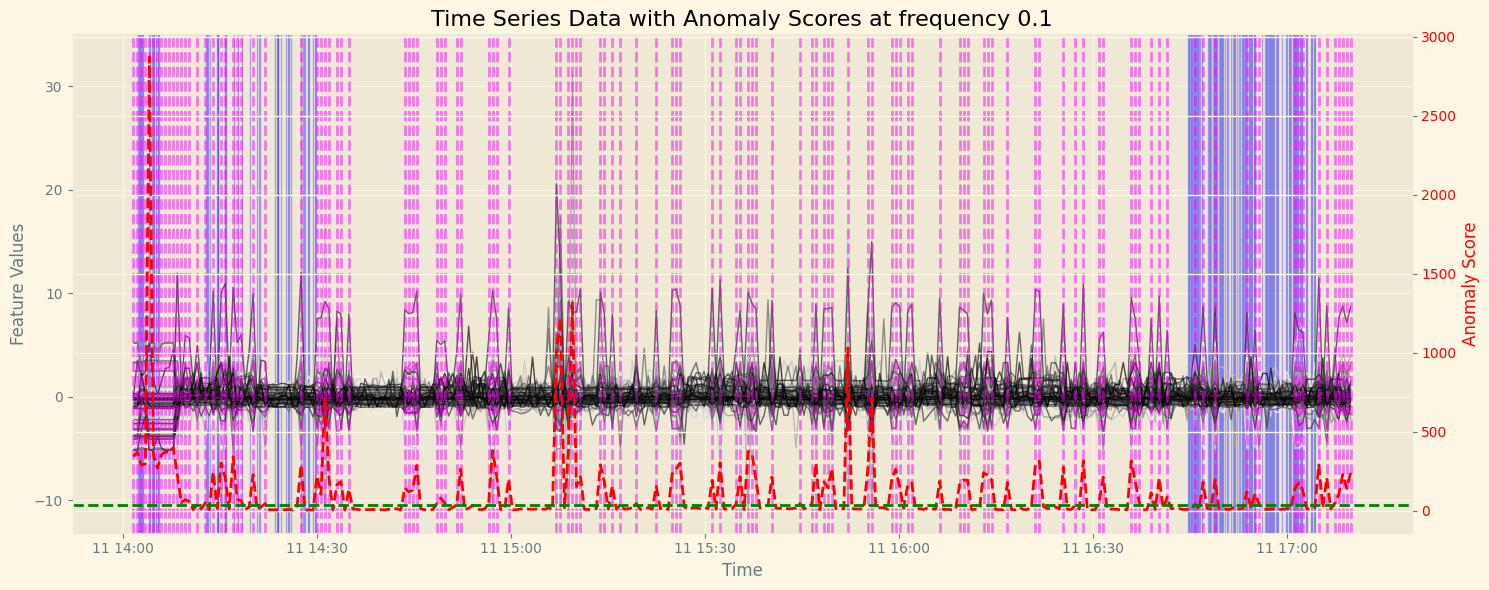

Top 120 Anomalies:
                        timestamp  anomaly_score  \
4   2022-08-11 14:04:02.788550819    2871.373047   
110 2022-08-11 15:09:28.619147540    1325.903076   
107 2022-08-11 15:07:37.510734426    1220.529053   
179 2022-08-11 15:52:04.112649180    1029.782349   
106 2022-08-11 15:07:00.474596721    1027.572998   
..                            ...            ...   
266 2022-08-11 16:45:46.256629508      41.842331   
16  2022-08-11 14:11:27.222203278      41.070854   
122 2022-08-11 15:16:53.052800000      38.237194   
81  2022-08-11 14:51:34.571154098      37.379387   
236 2022-08-11 16:27:15.172498360      36.608574   

     machine_nameKuka Robot_apparent_power-_Average power  \
4                                            -5.323114      
110                                          -0.911260      
107                                          -1.181816      
179                                          -1.338344      
106                                          -1.885

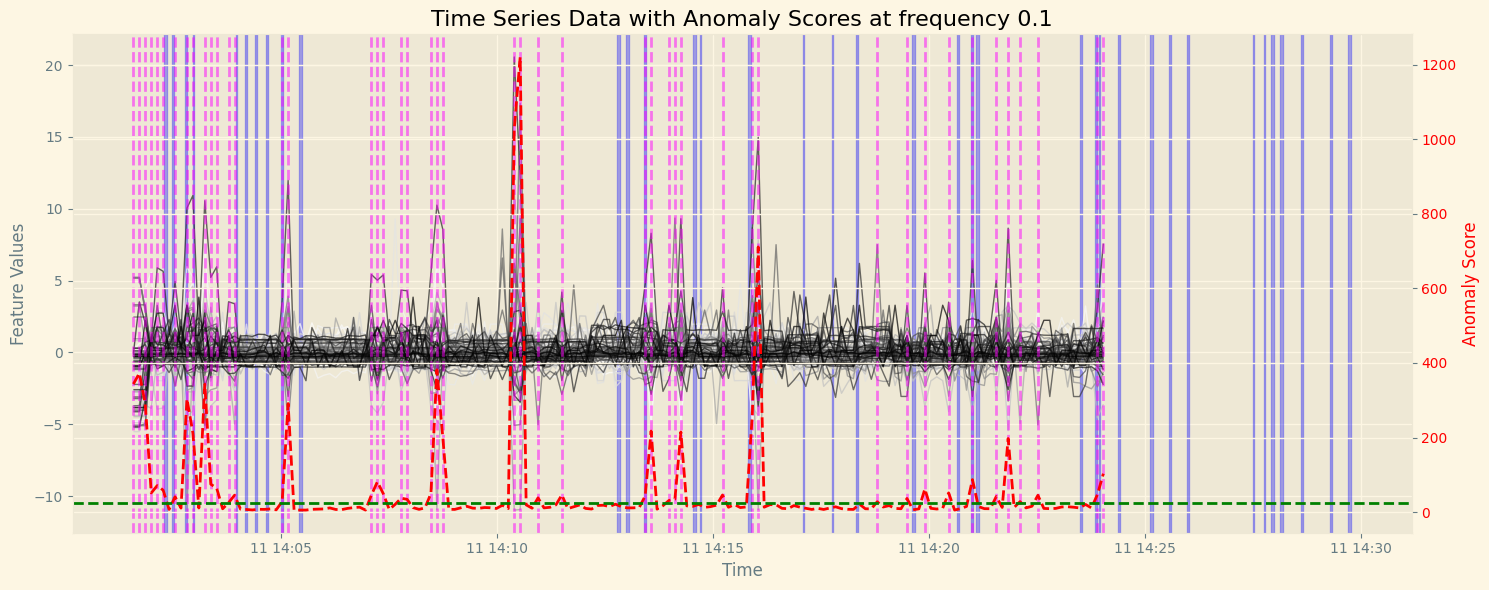

Top 47 Anomalies:
                  timestamp  anomaly_score  \
65  2022-08-11 14:10:31.934    1220.529053   
64  2022-08-11 14:10:23.668    1027.572998   
105 2022-08-11 14:16:02.574     711.021484   
51  2022-08-11 14:08:36.210     381.508209   
1   2022-08-11 14:01:42.910     372.456818   
0   2022-08-11 14:01:34.644     343.456818   
12  2022-08-11 14:03:13.836     342.906189   
9   2022-08-11 14:02:49.038     303.807312   
26  2022-08-11 14:05:09.560     291.148071   
2   2022-08-11 14:01:51.176     289.279144   
104 2022-08-11 14:15:54.308     260.358337   
87  2022-08-11 14:13:33.786     217.338074   
92  2022-08-11 14:14:15.116     214.808655   
10  2022-08-11 14:02:57.304     212.075729   
52  2022-08-11 14:08:44.476     199.432495   
147 2022-08-11 14:21:49.746     197.468521   
163 2022-08-11 14:24:02.002     103.060005   
141 2022-08-11 14:21:00.150      87.150681   
41  2022-08-11 14:07:13.550      81.285156   
13  2022-08-11 14:03:22.102      74.973709   
4   2022-08-11 1

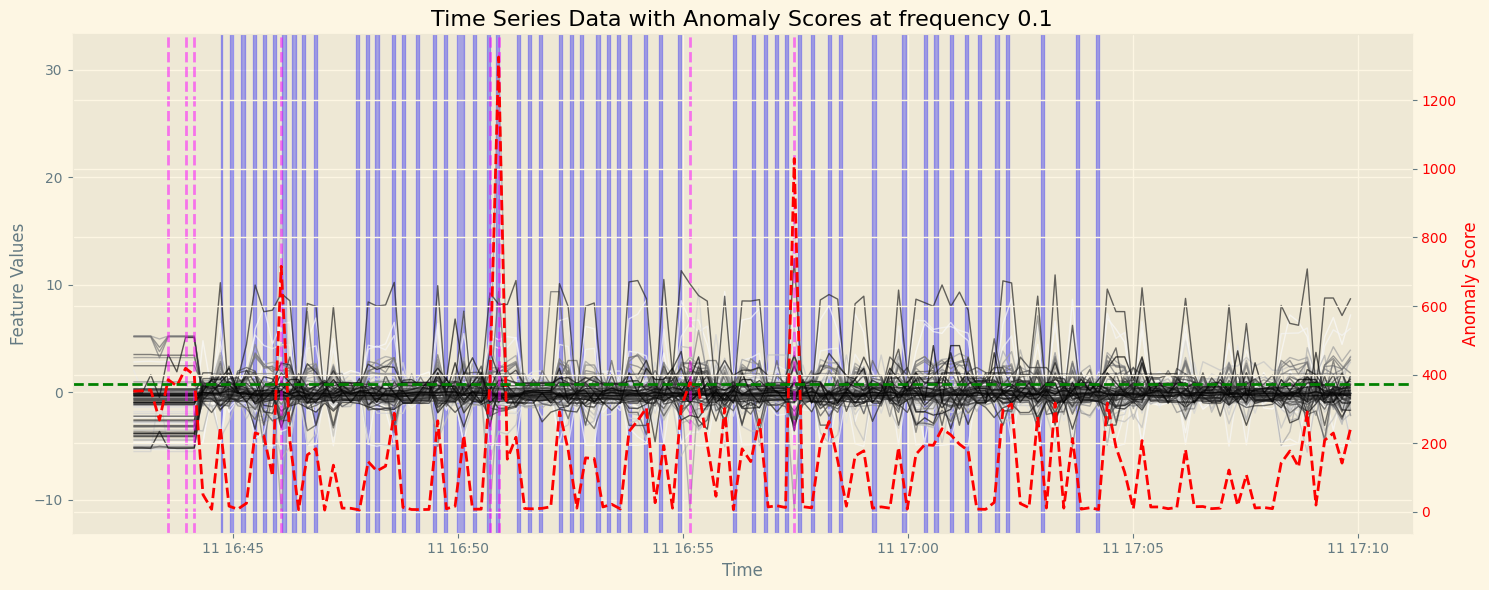

Top 8 Anomalies:
                       timestamp  anomaly_score  \
42 2022-08-11 16:50:54.503700000    1325.903076   
76 2022-08-11 16:57:28.682457142    1029.782349   
17 2022-08-11 16:46:04.666378571     715.876343   
6  2022-08-11 16:43:57.137957142     418.424438   
7  2022-08-11 16:44:08.731450000     398.381958   
4  2022-08-11 16:43:33.950971428     385.220947   
41 2022-08-11 16:50:42.910207142     376.311798   
64 2022-08-11 16:55:09.560542857     376.262512   

    machine_nameKuka Robot_apparent_power-_Average power  \
42                                          -0.911260      
76                                          -1.338344      
17                                          -0.707436      
6                                           -5.317735      
7                                           -5.323762      
4                                           -5.333378      
41                                          -0.850698      
64                                         

In [45]:
plot_anomalies_over_time(X_test, anomaly_scores, anomalies_detected, freq, thresholds[1], collisions_zones , X_test_start_end)
plot_anomalies_over_time(X_test1, anomaly_scores1, anomalies_detected1, freq, thresholds_1[1], collisions_zones_1, X_test_start_end1)
plot_anomalies_over_time(X_test5, anomaly_scores5, anomalies_detected5, freq, thresholds_5[1], collisions_zones_5, X_test_start_end5)